In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

# from keras import Sequential
# from keras.layers import Lambda, Dense, Flatten
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Lambda, Dense, Flatten
from keras import backend as K 

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

In [38]:
N = 100000
N2 = int(N/2)

sr_s1, sr_s2, sb_s1, sb_s2 = 0.1, -0.1, 0.05, 0
# sr_s1, sr_s2, sb_s1, sb_s2 = 0, 0, 0, 0
SR_background_data = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)
SB_background_data = np.random.multivariate_normal([1,0],[[1,0],[0,1]],N)
SR_background_sim = np.random.multivariate_normal([sr_s1,sr_s2],[[1,0],[0,1]],N)
SB_background_sim = np.random.multivariate_normal([1 + sb_s1,sb_s2],[[1,0],[0,1]],N)

SR_signal = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N)

SR_background_data_fortest = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N*10)
SR_signal_fortest = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N*10)

EPOCHS = 100

Text(0, 0.5, 'events')

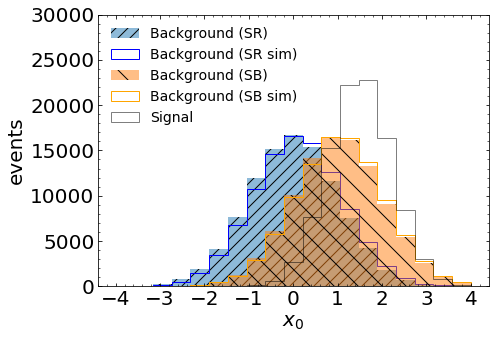

In [39]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SR_background_sim[:, 0], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SR sim)', color='blue')
plt.hist(SB_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SB_background_sim[:, 0], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SB sim)', color='orange')
plt.hist(SR_signal[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_0$",fontsize=20)
plt.ylabel("events",fontsize=20)

# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)

Text(0, 0.5, 'events')

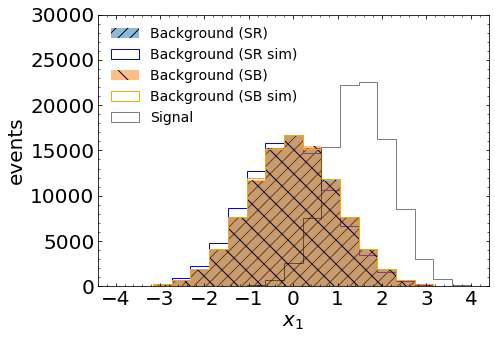

In [40]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SR_background_sim[:, 1], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SR sim)', color='blue')
plt.hist(SB_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SB_background_sim[:, 1], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SB sim)', color='orange')
plt.hist(SR_signal[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("events",fontsize=20)

# plt.savefig('plots/x1.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x1.pdf', bbox_inches='tight', padinches=0)

In [41]:
#First, let's do fully supervised

X_sup_train = np.concatenate([SR_signal,SR_background_data])
Y_sup_train = np.concatenate([np.ones(len(SR_signal)),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_sup_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [42]:
model_sup = Sequential()
model_sup.add(Dense(64, input_dim=2, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup = model_sup.predict(X_sup_val,batch_size=int(0.1*len(X_sup_val)))
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/100
200000/200000 [==============================] - 1s 3us/step - loss: 0.6933 - acc: 0.5383
Epoch 2/100
200000/200000 [==============================] - 0s 0us/step - loss: 0.5688 - acc: 0.8009
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4705 - acc: 0.8379
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.3782 - acc: 0.8683
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.3114 - acc: 0.8829
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2773 - acc: 0.8881
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2632 - acc: 0.8915
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2553 - acc: 0.8944
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2503 - acc: 0.8964
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8990
Epoch 81/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8992
Epoch 82/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8991
Epoch 83/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8991
Epoch 84/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8991
Epoch 85/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8992
Epoch 86/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2441 - acc: 0.8993
Epoch 87/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2441 - acc: 0.8991
Epoch 88/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2442 - acc: 0.8992
Epoch 89/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.24

In [43]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,1], Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d = model_sup1d.predict(X_sup_val[:,1],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d, tpr_sup1d, _ = roc_curve(Y_sup_val, scores_sup1d)

Epoch 1/100
200000/200000 [==============================] - 1s 3us/step - loss: 0.6560 - acc: 0.6611
Epoch 2/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5633 - acc: 0.7517
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4950 - acc: 0.7673
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4499 - acc: 0.7896
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4229 - acc: 0.8070
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4118 - acc: 0.8130
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4100 - acc: 0.8134
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4102 - acc: 0.8134
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4100 - acc: 0.8135
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

200000/200000 [==============================] - 0s 1us/step - loss: 0.4095 - acc: 0.8133
Epoch 81/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4095 - acc: 0.8135
Epoch 82/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4096 - acc: 0.8135
Epoch 83/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8135
Epoch 84/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8135
Epoch 85/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8135
Epoch 86/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4095 - acc: 0.8135
Epoch 87/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4095 - acc: 0.8134
Epoch 88/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8134
Epoch 89/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.40

In [10]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,0], Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d_x0 = model_sup1d.predict(X_sup_val[:,0],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d_x0, tpr_sup1d_x0, _ = roc_curve(Y_sup_val, scores_sup1d_x0)

Epoch 1/100
200000/200000 [==============================] - 0s 2us/step - loss: 0.6564 - acc: 0.6894
Epoch 2/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5823 - acc: 0.7575
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5165 - acc: 0.7707
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4638 - acc: 0.7874
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4284 - acc: 0.8060
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4124 - acc: 0.8130
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8135
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4095 - acc: 0.8138
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4094 - acc: 0.8138
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

In [44]:
Nsig = 500
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2])**0.5)
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2]))

2.23606797749979
0.01


In [45]:
n_injections = 10
signals_to_inject = [None] * n_injections
for i in range(n_injections):
    signals_to_inject[i] = SR_signal[np.random.choice(SR_signal.shape[0], size=Nsig, replace=False), :]

In [46]:
#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(n_injections):
    print('Training i = %i' % i)
    signal_to_inject = signals_to_inject[i]
    
    X_dvsim_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SR_background_sim[0:N2]])
    Y_dvsim_train = np.concatenate([np.ones(len(signal_to_inject)),np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SR_background_sim[0:N2]))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
#     tf.keras.backend.clear_session()
#     K.clear_session()
    
    # average over 5 models
    scores = [None] * 5
    for j in range(len(scores)):
        print('model', j)
        tf.keras.backend.clear_session()
        model_dvsim = Sequential()
        model_dvsim.add(Dense(64, input_dim=2, activation='relu')) 
        model_dvsim.add(Dense(64, activation='relu'))
        model_dvsim.add(Dense(64, activation='relu'))
        model_dvsim.add(Dense(1, activation='sigmoid'))
        model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        hist_dvsim = model_dvsim.fit(X_dvsim_train, Y_dvsim_train, epochs=EPOCHS, 
                                     batch_size=int(0.1*len(X_dvsim_train)), verbose=0)

        scores[j] = model_dvsim.predict(X_dvsim_val,batch_size=int(0.1*len(X_dvsim_val)))
        
    scores_dvsim = np.mean(scores, axis=0)
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

Training i = 0
model 0
model 1
model 2
model 3
model 4
Training i = 1
model 0
model 1
model 2
model 3
model 4
Training i = 2
model 0
model 1
model 2
model 3
model 4
Training i = 3
model 0
model 1
model 2
model 3
model 4
Training i = 4
model 0
model 1
model 2
model 3
model 4
Training i = 5
model 0
model 1
model 2
model 3
model 4
Training i = 6
model 0
model 1
model 2
model 3
model 4
Training i = 7
model 0
model 1
model 2
model 3
model 4
Training i = 8
model 0
model 1
model 2
model 3
model 4
Training i = 9
model 0
model 1
model 2
model 3
model 4


In [47]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(n_injections):
    print('Training i = %i' % i)
    signal_to_inject = signals_to_inject[i]
    
    X_ocwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SR_background_data[N2:-1]])
    Y_ocwola_train = np.concatenate([np.ones(len(signal_to_inject)),np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SR_background_data[N2:-1]))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    X_ocwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

    # average over 5 models
    scores = [None] * 5
    for j in range(len(scores)):
        print('model', j)
        tf.keras.backend.clear_session()
        model_ocwola = Sequential()
        model_ocwola.add(Dense(64, input_dim=2, activation='relu')) 
        model_ocwola.add(Dense(64, activation='relu'))
        model_ocwola.add(Dense(64, activation='relu'))
        model_ocwola.add(Dense(1, activation='sigmoid'))
        model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        hist_ocwola = model_ocwola.fit(X_ocwola_train, Y_ocwola_train, epochs=EPOCHS, 
                                     batch_size=int(0.1*len(X_ocwola_train)), verbose=0)
        
        scores[j] = model_ocwola.predict(X_ocwola_val,batch_size=int(0.1*len(X_ocwola_val)))
    
    scores_ocwola = np.mean(scores, axis=0)
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

Training i = 0
model 0
model 1
model 2
model 3
model 4
Training i = 1
model 0
model 1
model 2
model 3
model 4
Training i = 2
model 0
model 1
model 2
model 3
model 4
Training i = 3
model 0
model 1
model 2
model 3
model 4
Training i = 4
model 0
model 1
model 2
model 3
model 4
Training i = 5
model 0
model 1
model 2
model 3
model 4
Training i = 6
model 0
model 1
model 2
model 3
model 4
Training i = 7
model 0
model 1
model 2
model 3
model 4
Training i = 8
model 0
model 1
model 2
model 3
model 4
Training i = 9
model 0
model 1
model 2
model 3
model 4


In [48]:
# data v sim
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(dvsim_rocs)

for i, row in dvsim_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

dvsim_max = np.nanmax(fpr_interp, axis=0)
dvsim_min = np.nanmin(fpr_interp, axis=0)
dvsim_med = np.median(fpr_interp, axis=0)
dvsim_std = np.std(fpr_interp, axis=0)

# optimal CWoLa
tpr_pts = np.linspace(0, 1, 10000)
 
fpr_interp = [None] * len(ocwola_rocs)

for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

ocwola_mean = 1./np.mean(fpr_interp, axis=0)
fpr_interp = 1./np.array(fpr_interp)

ocwola_max = np.nanmax(fpr_interp, axis=0)
ocwola_min = np.nanmin(fpr_interp, axis=0)
ocwola_med = np.median(fpr_interp, axis=0)
ocwola_std = np.std(fpr_interp, axis=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, '10 classifiers')

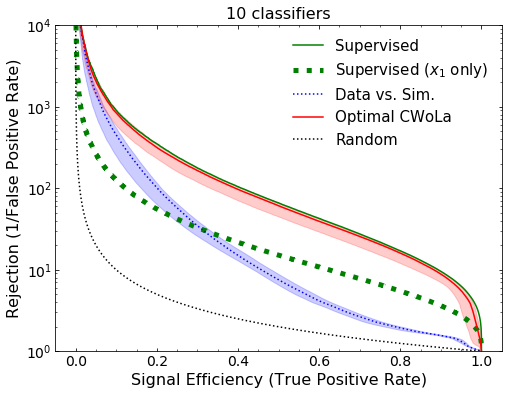

In [49]:
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med,label="Data vs. Sim.",color="blue",ls=":")
plt.fill_between(tpr_pts, dvsim_max, dvsim_min, color='blue', alpha=0.2)

plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.fill_between(tpr_pts, ocwola_max, ocwola_min, color='red', alpha=0.2)

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('10 classifiers', fontsize=16)

# plt.savefig('plots/toy_dvsim_ocwola_single_signal_clear_session.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/toy_dvsim_ocwola_single_signal_clear_session.pdf', bbox_inches='tight', padinches=0)

In [50]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(n_injections):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]
    
    X_cwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2], SB_background_data[N2:-1]])
    Y_cwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SB_background_data[N2:-1]))])

    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

    X_cwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models
    scores = [None] * 5
    for j in range(len(scores)):
        print('model', j)
        tf.keras.backend.clear_session()
        model_cwola = Sequential()
        model_cwola.add(Dense(64, input_dim=2, activation='relu')) 
        model_cwola.add(Dense(64, activation='relu'))
        model_cwola.add(Dense(64, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        hist_cwola = model_cwola.fit(X_cwola_train, Y_cwola_train, epochs=EPOCHS, 
                                     batch_size=int(0.1*len(X_cwola_train)), verbose=0)

        scores[j] = model_cwola.predict(X_cwola_val,batch_size=int(0.1*len(X_cwola_val)))
        
    scores_cwola = np.mean(scores, axis=0)
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

Training i = 0
model 0
model 1
model 2
model 3
model 4
Training i = 1
model 0
model 1
model 2
model 3
model 4
Training i = 2
model 0
model 1
model 2
model 3
model 4
Training i = 3
model 0
model 1
model 2
model 3
model 4
Training i = 4
model 0
model 1
model 2
model 3
model 4
Training i = 5
model 0
model 1
model 2
model 3
model 4
Training i = 6
model 0
model 1
model 2
model 3
model 4
Training i = 7
model 0
model 1
model 2
model 3
model 4
Training i = 8
model 0
model 1
model 2
model 3
model 4
Training i = 9
model 0
model 1
model 2
model 3
model 4


In [ ]:
#Next is SA-CWoLa

mylambda = 50

sacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(n_injections):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]

    X_sacwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SB_background_data[N2:-1],
                                      SR_background_sim[0:N2],SB_background_sim[N2:-1]])
    Y_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.zeros(len(SB_background_data[N2:-1])),
                                      np.ones(len(SR_background_sim[0:N2])),
                                      np.zeros(len(SB_background_sim[N2:-1]))])
    W_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.ones(len(SB_background_data[N2:-1])),
                                      -mylambda*np.ones(len(SR_background_sim[0:N2])),
                                      -mylambda*np.ones(len(SB_background_sim[N2:-1]))])

    X_sacwola_train, Y_sacwola_train, W_sacwola_train = shuffle(X_sacwola_train, Y_sacwola_train, W_sacwola_train)

    X_sacwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_sacwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models
    scores = [None] * 5
    for j in range(len(scores)):
        print('model', j)
        tf.keras.backend.clear_session()
    #     K.clear_session()
        model_sacwola = Sequential()
        model_sacwola.add(Dense(64, input_dim=2, activation='relu')) 
        model_sacwola.add(Dense(64, activation='relu'))
        model_sacwola.add(Dense(64, activation='relu'))
        model_sacwola.add(Dense(1, activation='sigmoid'))
        model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        hist_sacwola = model_sacwola.fit(X_sacwola_train, Y_sacwola_train, epochs=EPOCHS, 
                                         batch_size=int(0.1*len(X_sacwola_train)),sample_weight=W_sacwola_train,
                                         verbose=0
                                        )

        scores[j] = model_sacwola.predict(X_sacwola_val,batch_size=int(0.1*len(X_sacwola_val)))
        
    scores_sacwola = np.mean(scores, axis=0)
    fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_sacwola_val, scores_sacwola)
    sacwola_rocs = sacwola_rocs.append({'fpr': fpr_sacwola, 'tpr': tpr_sacwola}, ignore_index=True)

Training i = 0
model 0
model 1
model 2
model 3
model 4
Training i = 1
model 0


In [ ]:
# data v sim
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(dvsim_rocs)

for i, row in dvsim_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

dvsim_max = np.nanmax(fpr_interp, axis=0)
dvsim_min = np.nanmin(fpr_interp, axis=0)
dvsim_med = np.median(fpr_interp, axis=0)

# optimal CWoLa
fpr_interp = [None] * len(ocwola_rocs)

for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

ocwola_max = np.nanmax(fpr_interp, axis=0)
ocwola_min = np.nanmin(fpr_interp, axis=0)
ocwola_med = np.median(fpr_interp, axis=0)

# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

cwola_max = np.nanmax(fpr_interp, axis=0)
cwola_min = np.nanmin(fpr_interp, axis=0)
cwola_med = np.median(fpr_interp, axis=0)

# SA-CWoLa
fpr_interp = [None] * len(sacwola_rocs)

for i, row in sacwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

sacwola_max = np.nanmax(fpr_interp, axis=0)
sacwola_min = np.nanmin(fpr_interp, axis=0)
sacwola_med = np.median(fpr_interp, axis=0)

In [ ]:
# Plot without banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med, label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.pdf', bbox_inches='tight', padinches=0)

In [ ]:
# Plot with banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med,label="Data vs. Sim.",color="blue",ls=":")
plt.fill_between(tpr_pts, dvsim_max, dvsim_min, color='blue', alpha=0.2)

plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.fill_between(tpr_pts, ocwola_max, ocwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.fill_between(tpr_pts, cwola_max, cwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")
plt.fill_between(tpr_pts, sacwola_max, sacwola_min, color='orange', alpha=0.2)

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50_banded.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50_banded.pdf', bbox_inches='tight', padinches=0)

In [ ]:
# Plot individual bands

bands = {'dvsim': (dvsim_max, dvsim_med, dvsim_min, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
         'ocwola': (ocwola_max, ocwola_med, ocwola_min, {'label':'Optimal CWoLa', 'color':'red'}),
         'cwola': (cwola_max, cwola_med, cwola_min, {'label':'CWoLa', 'color':'red', 'ls':':'}),
         'sacwola': (sacwola_max, sacwola_med, sacwola_min, {'label':'SA-CWoLa', 'color':'orange'})
        }

fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.1, 1]) 

for i, key in enumerate(bands):
    row = 2 * math.floor(i / 2)
    col = i % 2
    
    ax0 = plt.subplot(gs[row, col])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.yscale("log")
    plt.ylim([1,1e4])
    
    line_max, line_med, line_min, opt = bands[key]

    plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
    plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

    plt.plot(tpr_pts, line_med, **opt)
    plt.fill_between(tpr_pts, line_max, line_min, color=opt['color'], alpha=0.2)

    plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

    plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
    plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
    plt.legend(frameon=False,fontsize=12,loc="upper right")
    
    plt.title(opt['label'], fontsize=16)

# plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")
plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50_separate.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50_separate.pdf', bbox_inches='tight', padinches=0)